In [1]:
from collections import defaultdict
from typing import Tuple
import numpy as np
import pandas as pd
from parse_logs import parse_log, comparisons

# Symbolic Defaults by 'complexity' of expression
In this notebook we take a look at the results of running the script at its default settings, this means:
 - evaluation across all tasks
 - recording the pareto front of symbolic defaults after each search
 - evaluating in-sample and out-of-sample performance of those dynamic defaults, as well as some pre-defined ones
 
**note:** The console cut off results for the first few tasks, so I am rerunning those now.

In [2]:
df, expressions_by_length, generations_by_task = parse_log('runs/rpart.log')

The predefined defaults are:
 * mlr_default := make_tuple(0.01, 30., 1., 20.)


For each task we will extract:
 - the number of generations optimization ran for (max=200)
 - max length expression
 - in and out of sample performance for length 1, 2 and 3 expression

For each task save the benchmark results. We also save results for length 1, 2 and 3 solutions as well as the best one found (that may be longer). Specifically we record:
 - best in_sample performance at length 1, 2, 3
 - best in_sample performance for any length
 - average out_sample performance by length for length 1, 2, 3
 - average out_sample performance for the longest (i.e. best in-sample score) solution(s).

In [3]:
for length, expressions in sorted(expressions_by_length.items()):
    m = max(set(expressions), key=expressions.count)
    print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")

 Found 115 expressions of length 0. Most frequent: mlr_default (115 times)
 Found 171 expressions of length 1. Most frequent: make_tuple(0.00390625, 16.0, 10.0, 32.0) (49 times)
 Found 260 expressions of length 2. Most frequent: make_tuple(truediv(0.00390625, m), 32.0, 10.0, 32.0) (34 times)
 Found 213 expressions of length 3. Most frequent: make_tuple(mul(mul(0.00390625, mcp), mcp), 32.0, 9.0, 32.0) (3 times)
 Found 151 expressions of length 4. Most frequent: make_tuple(mul(mul(0.00390625, mcp), mcp), 32.0, 9.0, truediv(9.0, xvar)) (2 times)
 Found 107 expressions of length 5. Most frequent: make_tuple(min(if_gt(mul(0.3519769920459628, m), xvar, rc, 10.0), 0.00390625), mul(m, 10.0), 10.0, 32.0) (1 times)
 Found  65 expressions of length 6. Most frequent: make_tuple(mul(mcp, mul(add(mcp, add(mcp, mcp)), truediv(16.0, n))), n, 9.0, 16.0) (1 times)
 Found  38 expressions of length 7. Most frequent: make_tuple(mul(mul(truediv(32.0, n), mcp), mcp), mul(9.0, m), sub(mul(mcp, 16.0), m), 16.0

"Found `N` expressions of length `L`" here means across all the tasks' pareto fronts `N` solutions have length `L`.
Pareto fronts may contain duplicate entries.

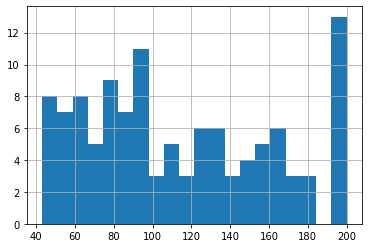

In [4]:
pd.Series(generations_by_task, name="generations").hist(bins=20)

In [5]:
pd.Series(generations_by_task, name="generations").median()

103.0

Above plot shows the histogram of the number of generations across tasks (binsize=10).
Note that if something ran for less than 200 generations, it found its optimum 20 generations earlier and early stopping terminated search.

In [6]:
comparison, df_out = comparisons(df)

We compare the scores and note which solution leads to the best out of sample score per task. A solution wins **alone** if all other solutions have worse performance. It wins **shared** if at least one other solution has the same score, but no solution has a better score. **either** is the sum of alone and shared.

But tallying wins does not say much about the robustness of the symbolic defaults. We can also compare the average or median distance from the top performer:

In [9]:
comparison

,mlr_default,score-1,score-2,score-3,score-best
alone,21,9,12,14,22
shared,0,2,23,27,32
either,21,11,35,41,54


In [7]:
d_cols = [c for c in df_out.columns if c.startswith('d_')]
df_out[d_cols].mean()

d_score-1        0.073415
d_score-2        0.043295
d_score-3        0.035179
d_score-best     0.027800
d_mlr_default    0.124273
d_max            0.000000
dtype: float64

In [8]:
df_out[d_cols].median()

d_score-1        0.0368
d_score-2        0.0042
d_score-3        0.0033
d_score-best     0.0001
d_mlr_default    0.0720
d_max            0.0000
dtype: float64

Looking at in-sample performance:

In [10]:
in_sample = df.index.map(lambda idx: idx[1] == "in-sample")
df.loc[in_sample].idxmax(axis=1).value_counts()

score-best    76
score-3       26
score-2       13
dtype: int64

`idxmax` reports the first column that has a max score of the row. So we see that never is the "score-1" solution the best in-sample. It is divided somewhat evenly between score-2, score-3 and scores for greater lengths. In 15 of 106 cases, it does not find the solution "symbolic best", which would have had better in-sample performance for that task (for other tasks we don't know if it was considered).

Reversing column order, we confirms there are no ties between any found solutions and benchmark ones (in-sample):

In [11]:
df.loc[in_sample][reversed(df.columns)].idxmax(axis=1).value_counts()

score-best    115
dtype: int64

In [12]:
df.loc[in_sample][reversed(df.columns)].idxmax(axis=1)

task    sample-type
3       in-sample      score-best
6       in-sample      score-best
11      in-sample      score-best
12      in-sample      score-best
14      in-sample      score-best
                          ...    
168911  in-sample      score-best
168912  in-sample      score-best
189928  in-sample      score-best
190411  in-sample      score-best
190412  in-sample      score-best
Length: 115, dtype: object